In [29]:
import sys
sys.path.append('../src')

import torch
from torch import nn

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
from tqdm.auto import tqdm
from timeit import default_timer as timer


from helper_functions import train_step, test_step, accuracy_fn, print_train_time
from baseline_model import BaselineModel
from enhanced_model import EnhancedModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
seed = 213
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
def run_model(cinic_train, cinic_test, model, loss_fn, optimizer, epochs=3, silent=True):
    time_start = timer()
    metrics = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # Train and test model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(data_loader=cinic_train, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device,
            silent=silent
        )
        test_loss, test_acc = test_step(data_loader=cinic_test,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device,
            silent=silent
        )

        # Append the metrics to the respective lists
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        metrics["test_loss"].append(test_loss)
        metrics["test_acc"].append(test_acc)

    time_end = timer()
    total_time = print_train_time(start=time_start,
                                  end=time_end,
                                  device=device)
    
    return metrics, total_time

### What I want to achieve in this notebook

train for 20 epochs 10 reruns 4 models how stable they are and if the model will overfit 


but first do it once, and plot results

In [13]:
epochs=60

In [14]:
cinic_directory = '../data'
cinic_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True, num_workers=6, pin_memory=True, persistent_workers=True)

cinic_test = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/test',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True, num_workers=6, pin_memory=True, persistent_workers=True)


model = BaselineModel(input_shape=3, 
    hidden_units=10, 
    output_shape=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

metrics, total_time = run_model(cinic_train, cinic_test, model, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/60 [00:00<?, ?it/s]


Train time on cuda: 251.508 seconds


## Plots for single run on baseline

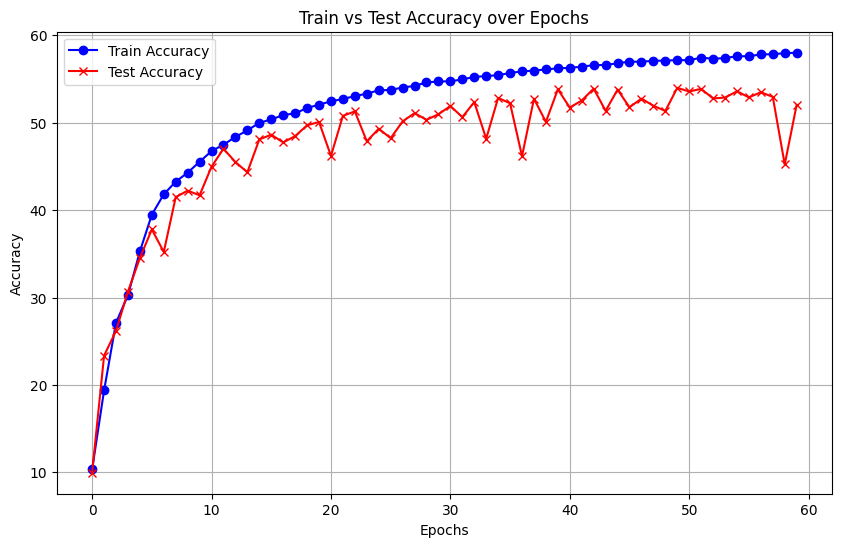

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), metrics["train_acc"], label="Train Accuracy", color="blue", marker='o')
plt.plot(range(epochs), metrics["test_acc"], label="Test Accuracy", color="red", marker='x')

plt.title("Train vs Test Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

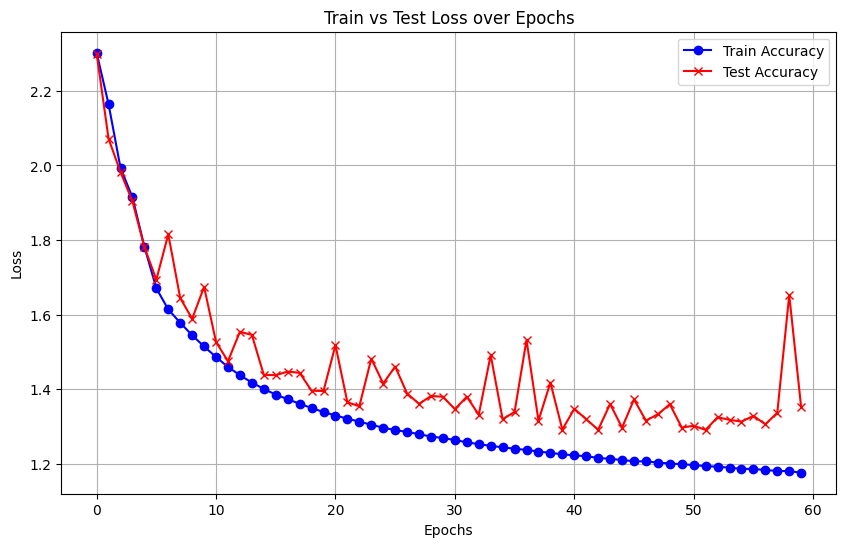

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), metrics["train_loss"], label="Train Accuracy", color="blue", marker='o')
plt.plot(range(epochs), metrics["test_loss"], label="Test Accuracy", color="red", marker='x')

plt.title("Train vs Test Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [ ]:
cinic_directory = '../data'
cinic_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True, num_workers=6, pin_memory=True, persistent_workers=True)

cinic_test = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/test',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True, num_workers=6, pin_memory=True, persistent_workers=True)


model = EnhancedModel(input_shape=3, 
    hidden_units=32, 
    output_shape=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

metrics, total_time = run_model(cinic_train, cinic_test, model, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/30 [00:00<?, ?it/s]


Train time on cuda: 162.319 seconds


## Plots for single run on enhanced

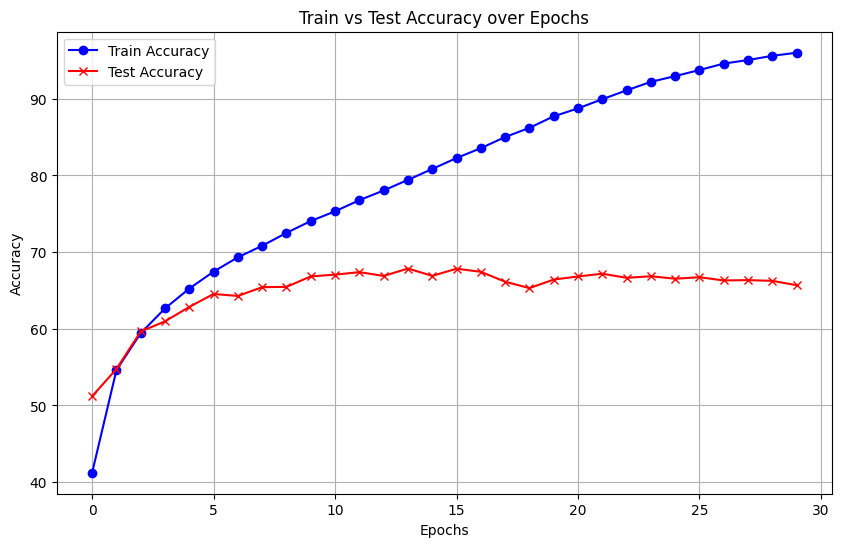

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), metrics["train_acc"], label="Train Accuracy", color="blue", marker='o')
plt.plot(range(epochs), metrics["test_acc"], label="Test Accuracy", color="red", marker='x')

plt.title("Train vs Test Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

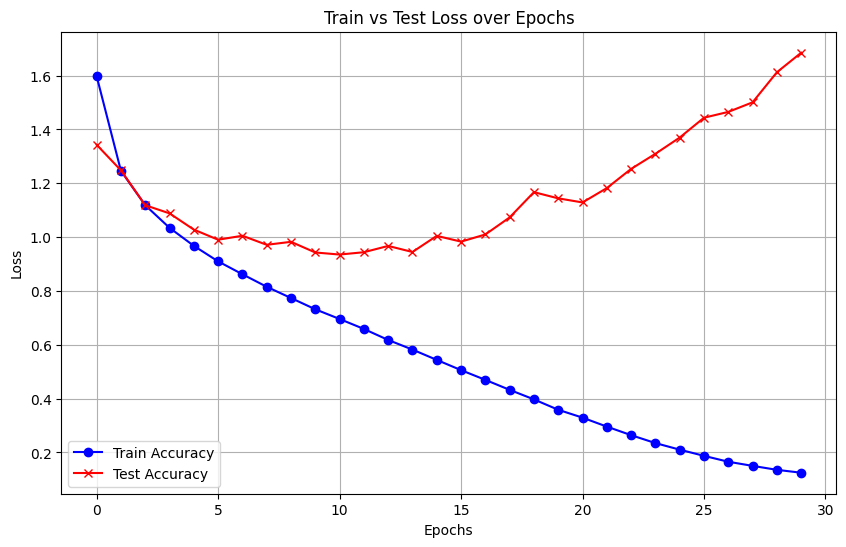

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), metrics["train_loss"], label="Train Accuracy", color="blue", marker='o')
plt.plot(range(epochs), metrics["test_loss"], label="Test Accuracy", color="red", marker='x')

plt.title("Train vs Test Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

It could be improved but it does not matter we have some point of reference 

based on those plots we can introduce scheduling of learning rate but nonetheless it is a good starting point 

In [17]:
epochs = 15
lr = 0.01
num_of_repeats = 10
metrics_list = []
total_time_list = []

cinic_directory = '../data'
cinic_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True, num_workers=6, pin_memory=True, persistent_workers=True)

cinic_test = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/test',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True, num_workers=6, pin_memory=True, persistent_workers=True)


for i in range(num_of_repeats):
    model = BaselineModel(input_shape=3, 
        hidden_units=10, 
        output_shape=10).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

    metrics, total_time = run_model(cinic_train, cinic_test, model, loss_fn, optimizer, epochs=epochs)
    
    metrics_list.append(metrics)
    total_time_list.append(total_time)


  0%|          | 0/15 [00:00<?, ?it/s]


Train time on cuda: 63.597 seconds


  0%|          | 0/15 [00:00<?, ?it/s]


Train time on cuda: 63.266 seconds


  0%|          | 0/15 [00:00<?, ?it/s]


Train time on cuda: 62.602 seconds


  0%|          | 0/15 [00:00<?, ?it/s]


Train time on cuda: 62.241 seconds


  0%|          | 0/15 [00:00<?, ?it/s]


Train time on cuda: 62.144 seconds


  0%|          | 0/15 [00:00<?, ?it/s]


Train time on cuda: 62.348 seconds


  0%|          | 0/15 [00:00<?, ?it/s]


Train time on cuda: 62.145 seconds


  0%|          | 0/15 [00:00<?, ?it/s]


Train time on cuda: 62.301 seconds


  0%|          | 0/15 [00:00<?, ?it/s]


Train time on cuda: 62.241 seconds


  0%|          | 0/15 [00:00<?, ?it/s]


Train time on cuda: 62.057 seconds


## Plot for multiple runs

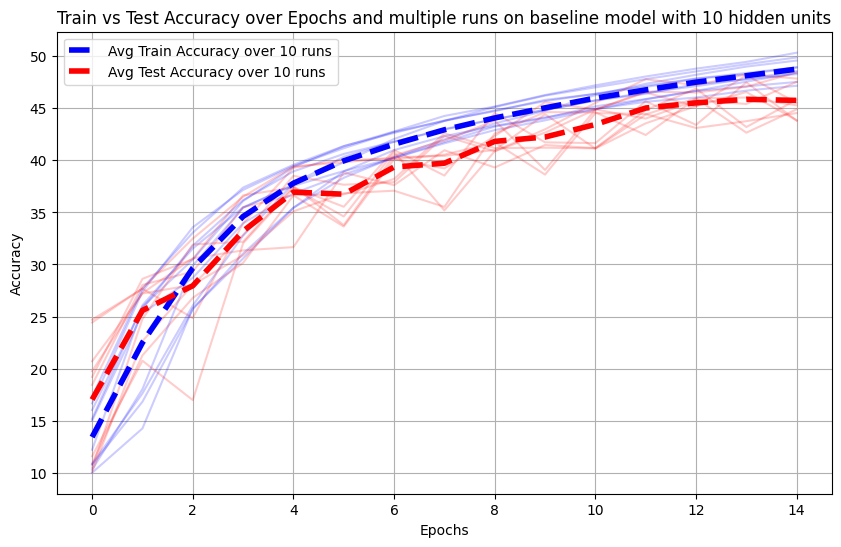

In [31]:
plt.figure(figsize=(10, 6))

for i, metrics in enumerate(metrics_list):
    plt.plot(range(epochs), metrics["train_acc"], color="blue", alpha=0.2)
    plt.plot(range(epochs), metrics["test_acc"], color="red", alpha=0.2)

# Calculate and plot average train accuracy
avg_train_loss = np.mean([metrics["train_acc"] for metrics in metrics_list], axis=0)
plt.plot(range(epochs), avg_train_loss, label="Avg Train Accuracy over 10 runs", color="blue", linestyle='--', linewidth=4)

# Calculate and plot average test accuracy
avg_test_loss = np.mean([metrics["test_acc"] for metrics in metrics_list], axis=0)
plt.plot(range(epochs), avg_test_loss, label="Avg Test Accuracy over 10 runs", color="red", linestyle='--', linewidth=4)

# Add title, labels, grid, legend
plt.title("Train vs Test Accuracy over Epochs and multiple runs on baseline model with 10 hidden units")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

plt.show()

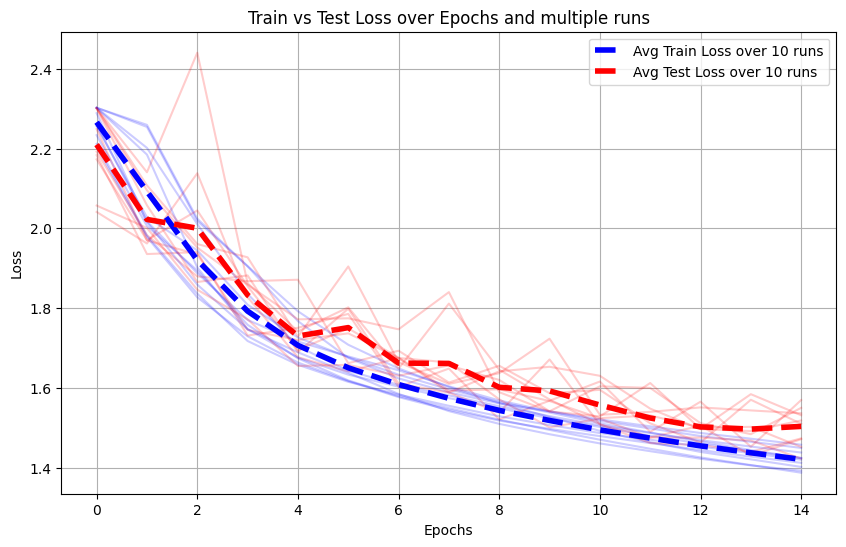

In [ ]:
plt.figure(figsize=(10, 6))

for i, metrics in enumerate(metrics_list):
    plt.plot(range(epochs), metrics["train_loss"], color="blue", alpha=0.2)
    plt.plot(range(epochs), metrics["test_loss"], color="red", alpha=0.2)

avg_train_loss = np.mean([metrics["train_loss"] for metrics in metrics_list], axis=0)
plt.plot(range(epochs), avg_train_loss, label="Avg Train Loss over 10 runs", color="blue", linestyle='--', linewidth=4)

avg_test_loss = np.mean([metrics["test_loss"] for metrics in metrics_list], axis=0)
plt.plot(range(epochs), avg_test_loss, label="Avg Test Loss over 10 runs", color="red", linestyle='--', linewidth=4)

# Add title, labels, grid, legend
plt.title("Train vs Test Loss over Epochs and multiple runs on baseline model with 10 hidden units")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.grid(True)

plt.show()

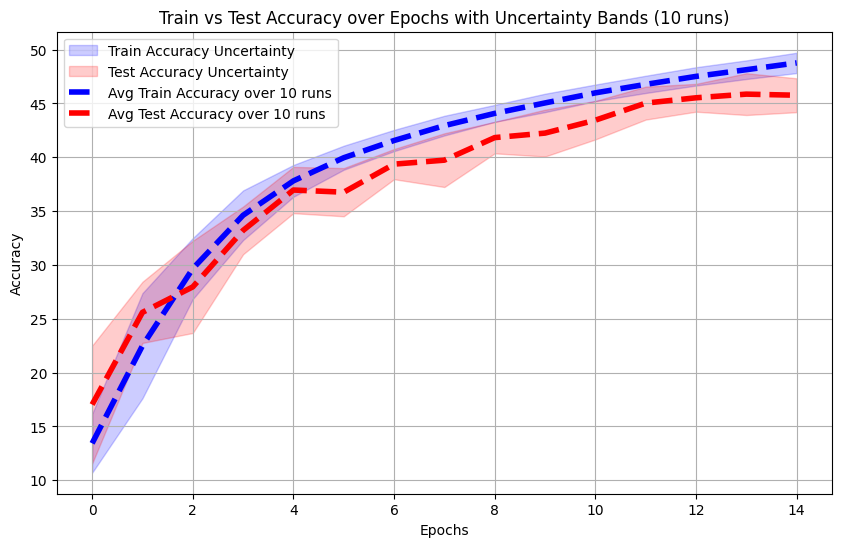

In [ ]:
plt.figure(figsize=(10, 6))


# Prepare lists of train and test accuracies for uncertainty bands
train_acc_list = [metrics["train_acc"] for metrics in metrics_list]
test_acc_list = [metrics["test_acc"] for metrics in metrics_list]

avg_train_acc = np.mean(train_acc_list, axis=0)
std_train_acc = np.std(train_acc_list, axis=0)

avg_test_acc = np.mean(test_acc_list, axis=0)
std_test_acc = np.std(test_acc_list, axis=0)

plt.fill_between(range(epochs), avg_train_acc - std_train_acc, avg_train_acc + std_train_acc, 
                 color="blue", alpha=0.2, label="Train Accuracy Uncertainty")

plt.fill_between(range(epochs), avg_test_acc - std_test_acc, avg_test_acc + std_test_acc, 
                 color="red", alpha=0.2, label="Test Accuracy Uncertainty")

plt.plot(range(epochs), avg_train_acc, label="Avg Train Accuracy over 10 runs", color="blue", linestyle='--', linewidth=4)
plt.plot(range(epochs), avg_test_acc, label="Avg Test Accuracy over 10 runs", color="red", linestyle='--', linewidth=4)

plt.title("Train vs Test Accuracy over Epochs with Uncertainty Bands (10 runs)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

plt.show()

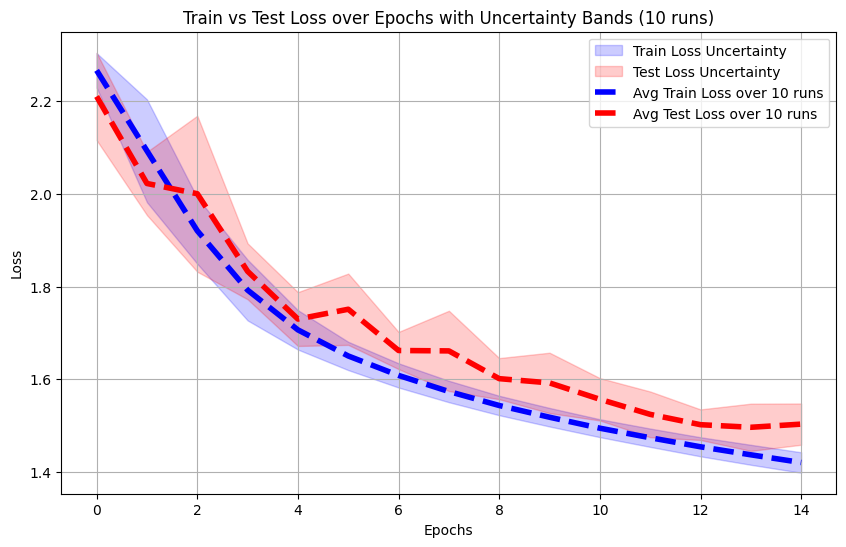

In [40]:

plt.figure(figsize=(10, 6))

train_loss_list = [metrics["train_loss"] for metrics in metrics_list]
test_loss_list = [metrics["test_loss"] for metrics in metrics_list]

avg_train_loss = np.mean(train_loss_list, axis=0)
std_train_loss = np.std(train_loss_list, axis=0)

avg_test_loss = np.mean(test_loss_list, axis=0)
std_test_loss = np.std(test_loss_list, axis=0)

plt.fill_between(range(epochs), avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, 
                 color="blue", alpha=0.2, label="Train Loss Uncertainty")

plt.fill_between(range(epochs), avg_test_loss - std_test_loss, avg_test_loss + std_test_loss, 
                 color="red", alpha=0.2, label="Test Loss Uncertainty")

plt.plot(range(epochs), avg_train_loss, label="Avg Train Loss over 10 runs", color="blue", linestyle='--', linewidth=4)
plt.plot(range(epochs), avg_test_loss, label="Avg Test Loss over 10 runs", color="red", linestyle='--', linewidth=4)

plt.title("Train vs Test Loss over Epochs with Uncertainty Bands (10 runs)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.grid(True)

plt.show()

### Trying to get as best score as possible just for fun

In [42]:
cinic_directory = '../data'
cinic_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True, num_workers=6, pin_memory=True, persistent_workers=True)

cinic_test = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/test',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True, num_workers=6, pin_memory=True, persistent_workers=True)


model = EnhancedModel(input_shape=3, 
    hidden_units=128, 
    output_shape=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

metrics, total_time = run_model(cinic_train, cinic_test, model, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/15 [00:00<?, ?it/s]


Train time on cuda: 414.939 seconds


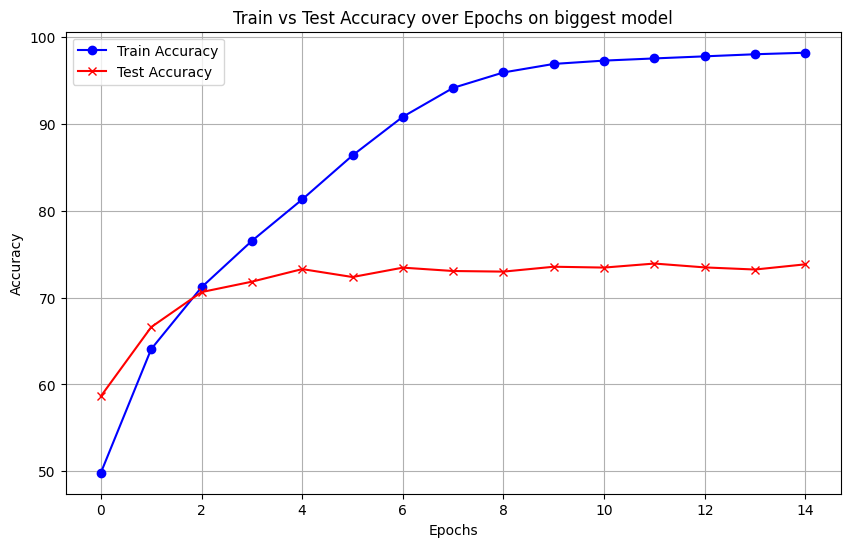

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), metrics["train_acc"], label="Train Accuracy", color="blue", marker='o')
plt.plot(range(epochs), metrics["test_acc"], label="Test Accuracy", color="red", marker='x')

plt.title("Train vs Test Accuracy over Epochs on biggest model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

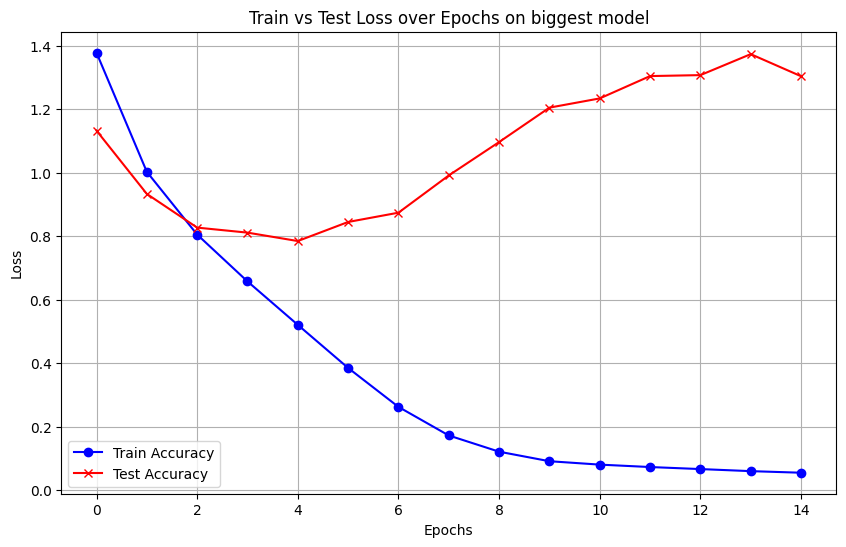

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), metrics["train_loss"], label="Train Accuracy", color="blue", marker='o')
plt.plot(range(epochs), metrics["test_loss"], label="Test Accuracy", color="red", marker='x')

plt.title("Train vs Test Loss over Epochs on biggest model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [46]:
metrics["test_acc"]

[58.65094171997157,
 66.60558813077469,
 70.63455046197583,
 71.83168976545842,
 73.27980632551528,
 72.36695984363895,
 73.4474946695096,
 73.05992359630419,
 72.98996090973704,
 73.55188343994314,
 73.45526830135039,
 73.91835465529495,
 73.47525764036958,
 73.2309434968017,
 73.8306236673774]

In [45]:
model = EnhancedModel(input_shape=3, 
    hidden_units=128, 
    output_shape=10).to(device)

summary(model, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
EnhancedModel                            [64, 10]                  --
├─Sequential: 1-1                        [64, 128, 16, 16]         --
│    └─Conv2d: 2-1                       [64, 128, 32, 32]         3,584
│    └─ReLU: 2-2                         [64, 128, 32, 32]         --
│    └─BatchNorm2d: 2-3                  [64, 128, 32, 32]         256
│    └─Conv2d: 2-4                       [64, 128, 32, 32]         147,584
│    └─ReLU: 2-5                         [64, 128, 32, 32]         --
│    └─BatchNorm2d: 2-6                  [64, 128, 32, 32]         256
│    └─MaxPool2d: 2-7                    [64, 128, 16, 16]         --
├─Sequential: 1-2                        [64, 256, 8, 8]           --
│    └─Conv2d: 2-8                       [64, 256, 16, 16]         295,168
│    └─ReLU: 2-9                         [64, 256, 16, 16]         --
│    └─BatchNorm2d: 2-10                 [64, 256, 16, 16]         512